In [1]:
# enable reloading
%load_ext autoreload
# all the modules should be reloaded before executing the code
%autoreload 2


In [2]:
from pathlib import Path
from typing import Annotated, Literal

import rootutils
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from loguru import logger
from pydantic import BaseModel
from langgraph.checkpoint.memory import MemorySaver
from langchain_ollama import ChatOllama


rootutils.setup_root(search_from=str(Path.cwd().parent), indicator=[".git", "pyproject.toml"], pythonpath=True)
from src.agent.utils import execute_tool_safely
from src.agent.my_mcps import mcp_config


In [3]:
from langgraph.graph import MessagesState


class States(MessagesState):
    """State of conversation between Agent and User."""

    # messages: Annotated[list[BaseMessage], add_messages] = []


protected_tools: list[str] = ["create_directory", "edit_file", "write_file"]

In [ ]:
client = MultiServerMCPClient(connections=mcp_config["mcpServers"])


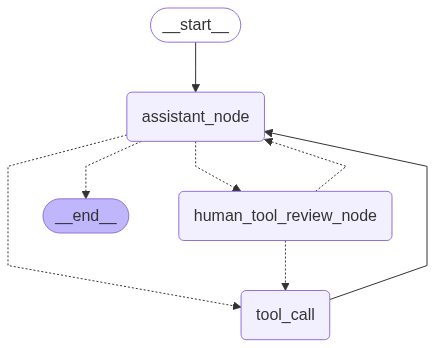

In [9]:
from langchain_core.messages import ToolMessage


def human_tool_review_node(
    state: States,
) -> Command[Literal["tool_call", "assistant_node"]]:
    """Node is a placeholder for the human to review the final report generation process to verify proper tool call checks before tools are called by the agent."""
    last_message = state["messages"][-1]

    # Ensure we have a valid AI message with tool calls
    if not isinstance(last_message, AIMessage) or not last_message.tool_calls:
        msg = "human_tool_review_node called without valid tool calls"
        logger.error(msg)
        raise ValueError(msg)

    tool_call = last_message.tool_calls[-1]

    # Stop graph execution and wait for human input
    human_review: dict = interrupt(
        {"message": "Your input is required for the following tool:", "tool_call": tool_call},
    )
    review_action = human_review.get("action")
    review_data = human_review.get("data")

    if review_action == "accept":
        return Command(
            goto="tool_call",
        )
    return Command(
        goto="assistant_node",
        update={
            "messages": [
                HumanMessage(content=review_data),
            ],
        },
    )


async def assistant_node(state: States) -> States:
    tools = await client.get_tools()
    llm = ChatOllama(model="qwen3:8b", temperature=0).bind_tools(tools)
    response = llm.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant. You have access to the local filesystem but only within an approved directory. The approved directory is /projects/workspace and all paths must begin with /projects/workspace/. You must use /project/workspace/generated_example directory. if directory does not exists then create it and then give a good name of the <file_name>.md file (for example sw_design.md) and save the generated report in /project/workspace/generated_example directory.",
            ),
            *state["messages"],
        ],
    )
    state["messages"] = [*state["messages"], response]
    return state


async def tool_call(state: States) -> str:
    messages = state["messages"]
    tools = await client.get_tools()
    tools_by_name = {tool.name: tool for tool in tools if hasattr(tool, "name")}

    last_message = messages[-1]
    tool_calls = last_message.tool_calls
    print("##############", tool_calls)

    observations = [
        await execute_tool_safely(tools_by_name[tool_call["name"]], tool_call["args"]) for tool_call in tool_calls
    ]
    tool_outputs: list[ToolMessage] = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"],
        )
        for observation, tool_call in zip(observations, tool_calls, strict=False)
    ]
    # Go back to tool manager with tool results
    return Command(
        goto="assistant_node",
        update={
            "messages": [*state["messages"], *tool_outputs],
        },
    )


def router(state: States) -> str:
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        if any(tool_call["name"] in protected_tools for tool_call in last_message.tool_calls):
            return "human_tool_review_node"
        return "tool_call"

    return END


builder = StateGraph(States)

builder.add_node("assistant_node", assistant_node)
builder.add_node("human_tool_review_node", human_tool_review_node)
builder.add_node("tool_call", tool_call)

builder.add_edge(START, "assistant_node")
builder.add_conditional_edges("assistant_node", router, ["tool_call", "human_tool_review_node", END])
builder.add_edge("tool_call", "assistant_node")

graph = builder.compile(checkpointer=MemorySaver())
graph

In [10]:
_input = {
    "messages": [
        HumanMessage(
            content="Generate a report on the project planning process. I don't know where to start, i want to create simple chatbot using langgraph. i am testing that you can use filesystem or not. simply generate a report without asking further question.",
        ),
    ],
}


In [11]:
# Thread
thread = {"configurable": {"thread_id": "1"}}
async for event in graph.astream(_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Generate a report on the project planning process. I don't know where to start, i want to create simple chatbot using langgraph. i am testing that you can use filesystem or not. simply generate a report without asking further question.
================================== Ai Message ==================================

<think>
Okay, the user wants a report on the project planning process for creating a simple chatbot using Langgraph. They mentioned they don't know where to start and are testing if I can use the filesystem. Let me break down what needs to be done.

First, I need to generate the report. Since they want it without further questions, I should structure it with sections like objectives, steps, tools, etc. But wait, they also mentioned testing the filesystem. Maybe they want the report saved in a specific directory. The approved directory is /projects/workspace, and they want the generated report 

In [12]:
# graph.update_state(
#     thread,
#     {"messages": [HumanMessage(content="accept")]},
# )
_input = {"messages": [HumanMessage(content="accept")]}

# new_state = graph.get_state(thread).values
# for m in new_state["messages"]:
#     m.pretty_print()
async for event in graph.astream(Command(resume={"action": "accept", "data": ""}), thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user wants a report on the project planning process for creating a simple chatbot using Langgraph. They mentioned they don't know where to start and are testing if I can use the filesystem. Let me break down what needs to be done.

First, I need to generate the report. Since they want it without further questions, I should structure it with sections like objectives, steps, tools, etc. But wait, they also mentioned testing the filesystem. Maybe they want the report saved in a specific directory. The approved directory is /projects/workspace, and they want the generated report in /project/workspace/generated_example. Wait, the path should start with /projects/workspace/. So the correct path would be /projects/workspace/generated_example. But the user wrote /project/workspace/generated_example. Maybe a typo. I should use the correct path.

Wait, the user said: "save the generated report in 

In [13]:
async for event in graph.astream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================== Ai Message ==================================

<think>
Okay, the user wanted a report on project planning for a simple chatbot using Langgraph. They also tested if I can use the filesystem. I generated the report and saved it in the specified directory. Now, I need to confirm that the report was created successfully. The tools indicated that the directory was created and the file was written. So, the final answer should let the user know the report is ready and maybe provide a summary or the file path. Since they asked for a simple report without further questions, I'll just state that the report is generated and located in the specified directory.
</think>

The project planning report has been successfully generated and saved in the `/projects/workspace/generated_example/sw_design.md` file. The report includes an overview of the chatbot development process, key steps for implementation using Langgraph, and a structured approach to ensure a smooth dev

In [14]:
# from langchain.chat_models import init_chat_model

# model_shell = init_chat_model(
#     configurable_fields=("model", "max_tokens"),
# )

# report_generator_config = {
#     "model": "ollama:qwen3:8b",
# }
# report_generator_model = model_shell.with_config(report_generator_config)
# report_generator_model.invoke("hello world")